In [11]:
# imports 
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, median_absolute_error

import sys
sys.path.append('..')
sys.path.append('../src')
from src.DataHandling.processing import supervised_transform
import src.DataHandling.visualization as vis

from src.Models.baseline import Baseline

In [12]:
TURBINE_ID_BRITISH = 2 ### set turbine id here, nb: you have to run the notebook 'data_inspection.ipynb' first
TURBINE_ID_BRAZILIAN = 1 ### set turbine id here, nb: you have to run the notebook 'data_inspection.ipynb' first
HORIZONS = ['10min', 'Hourly', 'Daily']
BENCHMARKS = pd.read_csv('../results_wind.csv')
BENCHMARKS

,name,RMSE,MAE,horizon,test_start,test_end
0,Kelmarsh_2,145.602811,91.553768,10min,2020-07-01,2021-06-30 23:50:00
1,Kelmarsh_2,263.749456,183.285915,hourly,2020-07-01,2021-06-30 23:50:00
2,Kelmarsh_2,623.023208,510.709616,daily,2020-07-01,2021-06-30 23:50:00
3,"Turbine 1, Beberibe",55.417200,36.244988,10min,2014-05-18 18:50:00,2014-07-31 23:50:00
4,"Turbine 1, Beberibe",119.249865,81.943719,hourly,2014-05-18 18:50:00,2014-07-31 23:50:00
5,"Turbine 1, Beberibe",196.741606,151.508157,daily,2014-05-18 18:50:00,2014-07-31 23:50:00


In [13]:
results_brit = pd.DataFrame(data={'Horizon': HORIZONS, 'RMSE': BENCHMARKS['RMSE'][0:3], 'MAE': BENCHMARKS['MAE'][0:3]})
results_brit = pd.melt(results_brit, id_vars=['Horizon'], value_vars=['RMSE', 'MAE'], value_name='Benchmark', var_name='Metric', )

results_braz = pd.DataFrame(data={'Horizon': HORIZONS, 'RMSE': BENCHMARKS['RMSE'][3:6], 'MAE': BENCHMARKS['MAE'][3:6]})
results_braz = pd.melt(results_braz, id_vars=['Horizon'], value_vars=['RMSE', 'MAE'], value_name='Benchmark', var_name='Metric')

In [14]:
# load cleaned data
turbine_two = pd.read_csv(f'../data/cleaned/turbine_brit_{TURBINE_ID_BRITISH}.csv')

# use date column as index and convert to datetime
turbine_two['Date'] = pd.to_datetime(turbine_two['Date'])
turbine_two.set_index('Date', inplace=True)
#turbine_two.head()

In [15]:
# transform data into a supervised learning problem
X, y = supervised_transform(df=turbine_two, target_var="Power (kW)", time_steps_ahead=1, window_size=5)

In [16]:
# create train and test set
test_start_brit = pd.to_datetime(BENCHMARKS['test_start'][0])
test_end_brit = pd.to_datetime(BENCHMARKS['test_end'][0])
test_start_braz = pd.to_datetime(BENCHMARKS['test_start'][3]) 
test_end_braz = pd.to_datetime(BENCHMARKS['test_end'][3])

X_train, X_test = X.loc[:test_start_brit], X.loc[test_start_brit:test_end_brit]
y_train, y_test = y.loc[:test_start_brit], y.loc[test_start_brit:test_end_brit]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((218818, 45), (218818,), (50451, 45), (50451,))

# 1. Baseline Model

The simplest model involves using the latest available value as prediction, which, in our scenario, is stored in the 'Power (kW) (time -1)' column.

In [17]:
res = []
predictions = []

for horizon in HORIZONS:
    model = Baseline(data=turbine_two, horizon=horizon)
    model.fit(test_start=test_start_brit, test_end=test_end_brit)
    preds = model.predict()
    rmse = np.sqrt(mean_squared_error(y_true=model.y_test, y_pred=preds))
    mae = median_absolute_error(y_true=model.y_test, y_pred=preds)
    res.append([rmse, mae])
    predictions.append(preds)

results_brit['Baseline'] = np.ravel(np.array(res), order='F')

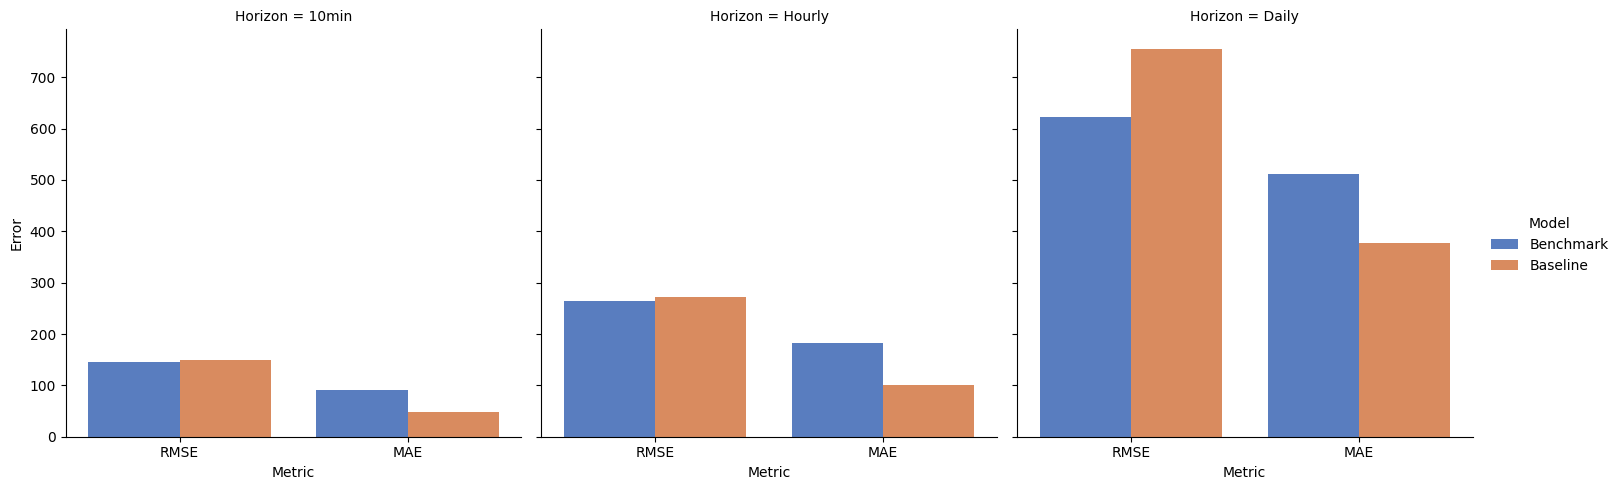

In [18]:
vis.barplot_errors(df=results_brit, models=['Benchmark', 'Baseline'])

**Analysis:**

# 2. Moving Average

**Explanation of the Model:**

# 3. Different kinds of Linear Regression